# 03. Conditional Parameter

通过上两个教程，您学习到了如何定义多参数的配置空间。但在一些特殊的场景，如AutoML场景下，您需要定义一个有条件依赖的空间。这个教程将分为两个部分讲解，1 为分层参数， 2 为条件与禁止语句。

## Hierarchical Parameter

试想，如果我们定义一个AutoML问题的配置空间，我们不仅要从学习器候选列表中对学习器进行选择，也就是**算法选择**（Algorithm Selection，AS），还要在选择学习器后对其超参数进行优化，也就是**超参优化**（HyperParameters Optimization，HPO）。

![CASH](https://img-blog.csdnimg.cn/20201223130020129.png)

举个例子，分类器我们可以从SVM、LDA、RandomForest等中选择（**算法选择**），如果我们选择了SVM分类器，我们还要对C、Gamma等参数进行优化（**超参优化**），如果Kernel选择了rbf，coeff$_0$参数会被激活$\cdots$

因此，我们需要定义一个分层配置空间。这个分层配置空间可以看成一个有向无环图（DAG），在实际操作中当做树来处理也可以。

我们先按照上图的描述，用HDL定义一个极简的分层配置空间

In [3]:
from ultraopt.hdl import hdl2cs, layering_config, plot_layered_dict, plot_hdl

In [4]:
HDL = {
    "Classifier(choice)":{
        "SVM": {
            "C":  {"_type": "loguniform", "_value": [0.01, 10000], "_default": 1.0},
        },
        "LDA": {
            "n_components":  {"_type": "int_uniform", "_value": [2, 9], "_default": 2},
        }
    }  
}

从上述的HDL定义可以看到，**算法选择变量**需用使用`(choice)`后缀，其值为一个字典，每个键表示候选算法名。

通过 `ultraopt.hdl.plot_hdl`可以对超参可视化：

- **六边形**结点 : 算法选择变量，即后缀为 `(choice)`的变量
- **矩形**结点 : 超参空间，不具备取值范围等实际意义，只起到**容纳超参变量**和**指示算法选择结果**的作用
- **椭圆形**结点 : 超参变量

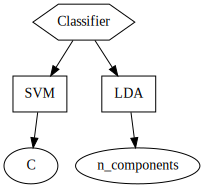

In [5]:
CS = hdl2cs(HDL)
plot_hdl(HDL)

在 `SVM` 这个超参空间内部，还可以继续定义算法选择配置空间。我们用HDL定义更复杂的分层配置空间：

In [6]:
HDL = {
    "Classifier(choice)":{
        "SVM": {
            "C":  {"_type": "loguniform", "_value": [0.01, 10000], "_default": 1.0},
            "kernel(choice)":  {
                "poly": {
                    "degree": {"_type": "int_uniform", "_value": [2, 5], "_default": 3}},
                "rbf": {
                    "coef0": {"_type": "quniform", "_value": [-1, 1], "_default": 0}},
                "sigmoid": {
                    "coef0": {"_type": "quniform", "_value": [-1, 1], "_default": 0}},
            }
        },
        "LDA": {
            "n_components":  {"_type": "int_uniform", "_value": [2, 9], "_default": 2},
            "solver(choice)":  {
                "lsgr": {
                    "shrinkage": {"_type": "choice", "_value": [True, False]}},
                "eigen": {
                    "shrinkage": {"_type": "choice", "_value": [True, False]}},
                "svd": {},
            }
        }
    }  
}

可视化这个HDL

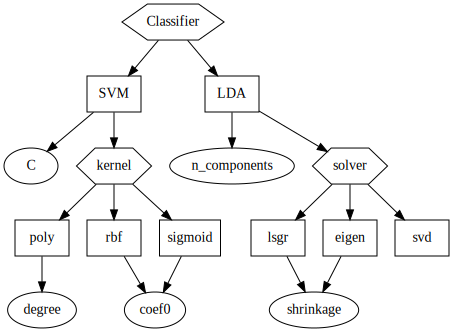

In [7]:
CS = hdl2cs(HDL)
plot_hdl(HDL)

## Layering Config

我们知道，UltraOpt优化的空间是配置空间(ConfigSpace对象)，用超参描述语言(HDL, dict对象)描述。从这个空间中采样可以得到配置(config, Configuration或dict对象)

现在我们尝试对上文得到的配置空间进行采样：

In [8]:
config = CS.get_default_configuration().get_dictionary() # 获取配置空间的默认配置
config

{'Classifier:__choice__': 'SVM',
 'Classifier:SVM:C': 1.0,
 'Classifier:SVM:kernel:__choice__': 'poly',
 'Classifier:SVM:kernel:poly:degree': 3}

可以看到，这个dict对象的配置是单层的，key的层次用`:`分割。

我们可以用`ultraopt.hdl.layering_config`函数对这个dict对象的`config`进行分层，得到`layered_config`

In [38]:
layered_dict = layering_config(config)

我们可以用`ultraopt.hdl.plot_layered_dict`函数对`layered_config`进行可视化

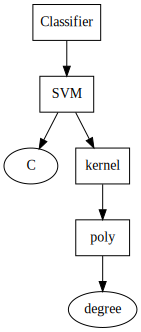

In [39]:
plot_layered_dict(layered_dict)

## Conditions and Forbidden Clauses

In [40]:
HDL = {
            "model(choice)": {
                "linearsvc": {
                    "max_iter": {"_type": "int_quniform", "_value": [300, 3000, 100], "_default": 600},
                    "penalty": {"_type": "choice", "_value": ["l1", "l2"], "_default": "l2"},
                    "dual": {"_type": "choice", "_value": [True, False], "_default": False},
                    "loss": {"_type": "choice", "_value": ["hinge", "squared_hinge"], "_default": "squared_hinge"},
                    "C": {"_type": "loguniform", "_value": [0.01, 10000], "_default": 1.0},
                    "__forbidden": [
                        {"penalty": "l1", "loss": "hinge"},
                        {"penalty": "l2", "dual": False, "loss": "hinge"},
                        {"penalty": "l1", "dual": False},
                        {"penalty": "l1", "dual": True, "loss": "squared_hinge"},
                    ]
                },
                "svc": {
                    "C": {"_type": "loguniform", "_value": [0.01, 10000], "_default": 1.0},
                    "kernel": {"_type": "choice", "_value": ["rbf", "poly", "sigmoid"], "_default": "rbf"},
                    "degree": {"_type": "int_uniform", "_value": [2, 5], "_default": 3},
                    "gamma": {"_type": "loguniform", "_value": [1e-05, 8], "_default": 0.1},
                    "coef0": {"_type": "quniform", "_value": [-1, 1], "_default": 0},
                    "shrinking": {"_type": "choice", "_value": [True, False], "_default": True},
                    "__activate": {
                        "kernel": {
                            "rbf": ["gamma"],
                            "sigmoid": ["gamma", "coef0"],
                            "poly": ["degree", "gamma", "coef0"]
                        }
                    }
                },
            }
        }

In [41]:
CS = hdl2cs(HDL)

In [42]:
CS

Configuration space object:
  Hyperparameters:
    model:__choice__, Type: Categorical, Choices: {linearsvc, svc}, Default: linearsvc
    model:linearsvc:C, Type: UniformFloat, Range: [0.01, 10000.0], Default: 1.0, on log-scale
    model:linearsvc:dual, Type: Categorical, Choices: {True:bool, False:bool}, Default: True:bool
    model:linearsvc:loss, Type: Categorical, Choices: {hinge, squared_hinge}, Default: squared_hinge
    model:linearsvc:max_iter, Type: UniformInteger, Range: [300, 3000], Default: 600, Q: 100
    model:linearsvc:penalty, Type: Categorical, Choices: {l1, l2}, Default: l2
    model:svc:C, Type: UniformFloat, Range: [0.01, 10000.0], Default: 1.0, on log-scale
    model:svc:coef0, Type: UniformFloat, Range: [-1.0, 1.0], Default: 0.0, Q: 1.0
    model:svc:degree, Type: UniformInteger, Range: [2, 5], Default: 3
    model:svc:gamma, Type: UniformFloat, Range: [1e-05, 8.0], Default: 0.1, on log-scale
    model:svc:kernel, Type: Categorical, Choices: {rbf, poly, sigmoid}, 

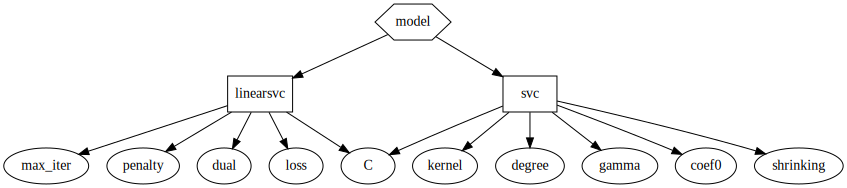

In [43]:
plot_hdl(HDL)